In [43]:
import numpy as np
import os,sys
import math
from sklearn.cluster import KMeans
from scipy import spatial
import scipy.stats as sp
import uproot



#--------------------------------------------------------------------------------------------------------------------------------------------

def getData(fname="", procName="Events"):
    file = uproot.open(fname)
    dq_dict = file[procName].arrays(library="np")
    dq_events = {
        "Hits":{
            "detID": dq_dict["hit_detID"],
            "edep": dq_dict["hit_edep"],
            "elmID": dq_dict["hit_elmID"],
            "hit_pos": dq_dict["hit_pos"]
        },
        "track":{
            "x": dq_dict["track_x_CAL"],
            "y": dq_dict["track_y_CAL"],
            "ID": dq_dict["eventID"],
            "pz": dq_dict["track_pz_st1"]
        },
        "st23": {
            "ntrack23": dq_dict["n_st23tracklets"],
            "px":   dq_dict["st23tracklet_px_st3"],
            "py":   dq_dict["st23tracklet_py_st3"],
            "pz":   dq_dict["st23tracklet_pz_st3"],
            "x":   dq_dict["st23tracklet_x_st3"],
            "y":   dq_dict["st23tracklet_y_st3"],
            "z":   dq_dict["st23tracklet_z_st3"],
            "Cal_x": dq_dict["st23tracklet_x_CAL"],
            "Cal_y": dq_dict["st23tracklet_y_CAL"]
        }
    }

    return dq_events
#--------------------------------------------------------------------------------------------------------------------------------------------

ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158 #sampling fraction of emcal
emin=0.0005
det_z={41: 2130.27, 42: 2146.45, 43:2200.44 , 44:2216.62 , 45:2251.71 , 46: 2234.29}
seed_threshold=0.2

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    x_pos, y_pos, eng, seed_pos = [], [], [], []

    for i in range(len(dq_hits["edep"])):
        emcal_x, emcal_y, emcal_edep, seeds, seedeng = emcal_byevent(dq_hits, i)
        x_pos.append(emcal_x)
        y_pos.append(emcal_y)
        eng.append(emcal_edep)
        seed_pos.append(seeds)

    return x_pos, y_pos, eng, seed_pos

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_byevent(dq_hits, evtNum):
    raw_elmID = dq_hits["elmID"][evtNum]
    raw_edep = dq_hits["edep"][evtNum]
    
    emcal_mask = dq_hits["detID"][evtNum] == 100
    eng_mask = raw_edep[emcal_mask] >= emin
    
    elmID = raw_elmID[emcal_mask][eng_mask]
    edep = raw_edep[emcal_mask][eng_mask]
    
    emcal_towerx = elmID // ntowersy
    emcal_towery = elmID % ntowersy
    emcal_edep = edep / sfc
    
    seed_coord, seed_eng = find_energy_seeds(emcal_towerx, emcal_towery, emcal_edep)
    
    emcal_x = ecalx[0] + emcal_towerx * sizex
    emcal_y = ecaly[0] + emcal_towery * sizey
   
    
    return emcal_x, emcal_y, emcal_edep, seed_coord, seed_eng

#--------------------------------------------------------------------------------------------------------------------------------------------

def find_energy_seeds(x_cell, y_cell, edep):
    energy_grid = np.zeros((ntowersx, ntowersx))
    energy_grid[x_cell, y_cell] = edep  # Assign energy values based on x_cell and y_cell indices
    
    seed_energy_mask = energy_grid > seed_threshold
    
    # Create padded version of the energy grid to handle edge cases
    padded_energy_grid = np.pad(energy_grid, pad_width=1, mode='constant', constant_values=0)
    
    # Pre-compute slices for neighbor comparison
    center_slice = padded_energy_grid[1:-1, 1:-1]
    neighbors = [
        padded_energy_grid[0:-2, 0:-2], padded_energy_grid[0:-2, 1:-1], padded_energy_grid[0:-2, 2:],
        padded_energy_grid[1:-1, 0:-2],                                   padded_energy_grid[1:-1, 2:],
        padded_energy_grid[2:  , 0:-2], padded_energy_grid[2:  , 1:-1], padded_energy_grid[2:  , 2:]
    ]
    
    # Find seeds: cells with energy > 0.2 and higher than all their neighbors
    seed_mask = seed_energy_mask & np.all(np.dstack([center_slice > neighbor for neighbor in neighbors]), axis=2)
    
    # Return indices of seeds
    seed_grids = np.argwhere(seed_mask)
    seed_eng = energy_grid[seed_mask]
    seed_coords = np.array([ecalx[0], ecaly[0]]) + seed_grids * np.array([sizex, sizey])
 
    
    return seed_coords, seed_eng

In [40]:
def plot_acceptance(mass, coupling, Nevent, acceptance, hue_norm = (0,1)):
    
    fig, ax = plt.subplots()
    im = ax.scatter(mass, coupling, c=acceptance, s=750, marker='s', cmap='Spectral_r',linewidths=0)

    fig.colorbar(im, ax=ax)

    plt.xlabel(r"$m_{A'}$ [GeV]")
    plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)

    # iterate over axes of FacetGrid
    labels = ax.get_yticks() # get y labels

    new_labels = []
    for i,l in enumerate(labels):
        new_labels.append(r"$10^{%s}$"%labels[i])

    ax.set_yticklabels(new_labels) # set new labels

    plt.show()
    
    
    



In [64]:
Aee_dir = "/Users/wongdowling/Desktop/n-tuples/Aee_500-600"
Amm_dir = "/Users/wongdowling/Desktop/n-tuples/Amm_500-600"

In [97]:
def scan_Aee(scan_dir):
    os.chdir(scan_dir)
    mass = []
    coupling = []
    nseed_trk = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("AeeBrem")& (not filename.endswith("_DST.root")):
            Ap_config = filename[:-5].split('_')
            dq_events = getData(filename, "Events")
            (x, y, eng, seed) = emcal_bytuple(dq_events)
            ntrk = sum(dq_events["st23"]["ntrack23"])
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-2]))
            nseed_trk.append(len(seed)/ntrk)
    return mass, coupling, nseed_trk, seed, ntrk

In [98]:
(a, b, c, d, e) = scan_Aee(Aee_dir)

KeyboardInterrupt: 

In [87]:
len(c)

443

In [88]:
type(c)

list

In [48]:
import matplotlib.pyplot as plt


/var/folders/mf/cqjfz_8x7tgbhvl955fzybtr0000gn/T/ipykernel_11908/4145328163.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


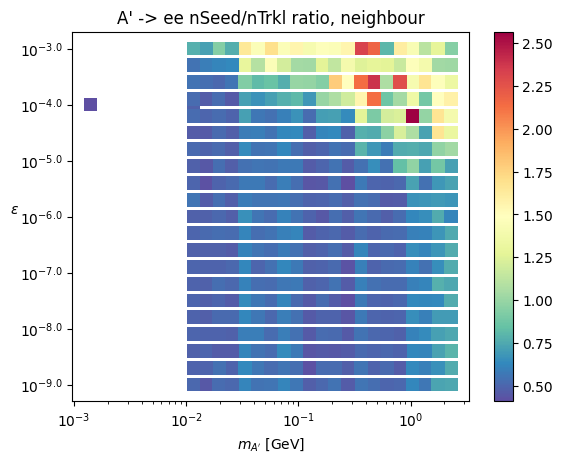

In [100]:
fig, ax = plt.subplots()
im = ax.scatter(a, b, c=c, s=98, marker='s', cmap='Spectral_r', linewidths=0)
fig.colorbar(im, ax=ax)

ax.set_title("A' -> ee nSeed/nTrkl ratio, neighbour")
plt.xlabel(r"$m_{A'}$ [GeV]")
plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)
ax.set_xscale("log")


# iterate over axes of FacetGrid
labels = ax.get_yticks() # get y labels

new_labels = []
for i,l in enumerate(labels):
    new_labels.append(r"$10^{%s}$"%labels[i])

ax.set_yticklabels(new_labels) # set new labels

plt.show()

In [76]:
def scan_Amm(scan_dir):
    os.chdir(scan_dir)
    mass = []
    coupling = []
    nseed_trk = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("AmmBrem")& (not filename.endswith("_DST.root")):
            Ap_config = filename[:-5].split('_')
            dq_events = getData(filename, "Events")
            (x, y, eng, seed) = emcal_bytuple(dq_events)
            ntrk = sum(dq_events["st23"]["ntrack23"])
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-2]))
            nseed_trk.append(len(seed)/ntrk)
    return mass, coupling, nseed_trk

In [77]:
(d, e, f) = scan_Amm(Amm_dir)

In [78]:
len(d)

609

/var/folders/mf/cqjfz_8x7tgbhvl955fzybtr0000gn/T/ipykernel_11908/1241618417.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


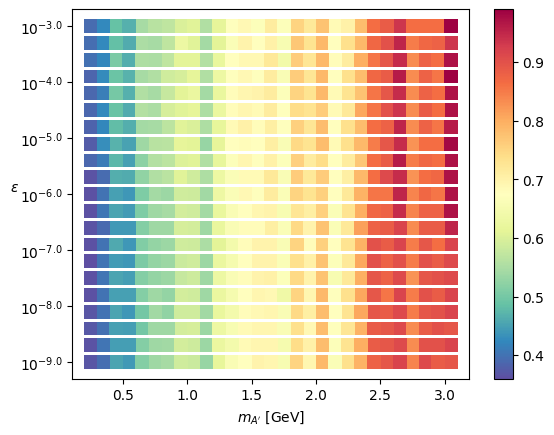

In [99]:
fig, ax = plt.subplots()
im = ax.scatter(d, e, c=f, s=98, marker='s', cmap='Spectral_r',linewidths=0)
fig.colorbar(im, ax=ax)

plt.xlabel(r"$m_{A'}$ [GeV]")
plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)
#ax.set_xscale("log")


# iterate over axes of FacetGrid
labels = ax.get_yticks() # get y labels

new_labels = []
for i,l in enumerate(labels):
    new_labels.append(r"$10^{%s}$"%labels[i])

ax.set_yticklabels(new_labels) # set new labels

plt.show()

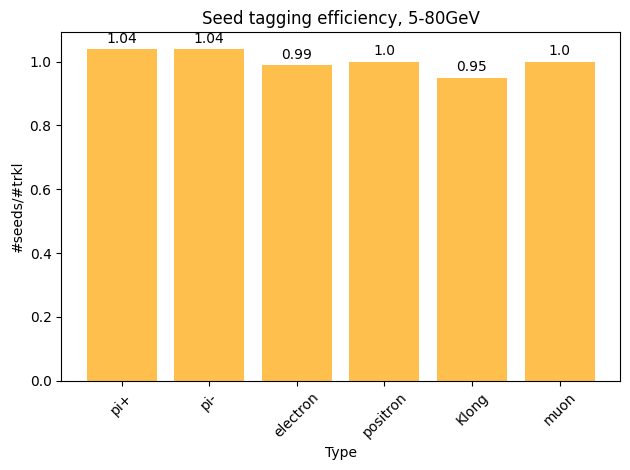

In [8]:
import matplotlib.pyplot as plt

# Your data
values = [1.04, 1.04, 0.99, 1.0, 0.95, 1.0]
types = ["pi+", "pi-", "electron", "positron", "Klong", "muon"]

# Create the histogram
bars = plt.bar(types, values, color='orange', alpha=0.7)

# Add labels and title
plt.xlabel('Type')
plt.ylabel('#seeds/#trkl')
plt.title('Seed tagging efficiency, 5-80GeV')
plt.xticks(rotation=45)  # Rotate the x-labels for better readability

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
# Display the histogram
plt.tight_layout()
plt.show()
